In [24]:
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import math
from IPython.display import clear_output

In [469]:
import tqdm

ModuleNotFoundError: No module named 'tqdm'

In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None

In [30]:
times=[]
with open('timelist.txt', 'r') as fp:
    for line in fp:
        times.append(line[:-1])

nodates=[]
with open('nodatelist.txt', 'r') as fp:
    for line in fp:
        nodates.append(line[:-1])

In [415]:
bnifty = pd.read_csv('banknifty_master.csv',low_memory=False,header=None,on_bad_lines='skip',names=["Strike", "Date", "Time", "Open","High","Low","Close","Volume"])
bnifty = bnifty[bnifty['Time'].isin(times)]
bnifty = bnifty[(bnifty.Date >= '2018/05/02') & (bnifty.Date <= '2020/02/14')]
bnifty = bnifty[~bnifty['Date'].isin(nodates)]
bnifty.reset_index(inplace=True)
bnifty.drop('index',axis=1,inplace=True)
bniftyeod = pd.read_csv('BNF_2018_2020_EOD.csv')[::-1]
bniftyeod['Date'] = pd.to_datetime(bniftyeod.Date)
bniftyeod['Date'] = bniftyeod['Date'].astype(str)
bniftyeod['Date'] = bniftyeod['Date'].apply(lambda line:line.replace('-', '/'))
bniftyeod = bniftyeod[~bniftyeod['Date'].isin(nodates)]
bniftyeod.reset_index(inplace=True)
bniftyeod.drop('index',axis=1,inplace=True)
bniftyu = pd.read_csv('BNF_2010_2020.csv',low_memory=False,on_bad_lines='skip')
bniftyu = bniftyu[(bniftyu.Date >= 20180502) & (bniftyu.Date <=20200214)]
bniftyu = bniftyu[bniftyu['Time'].isin(times)]
bniftyu['Date'] = bniftyu['Date'].astype(str)
bniftyu['Date'] = bniftyu['Date'].apply(lambda x:x[:4]+'/'+x[4:6]+'/'+x[6:])
# missingdates = list(set(bniftyu['Date']) - set(bnifty['Date']))
# missingdates=missingdates+['2019/04/24','2020/02/18','2020/03/13','2020/03/23']
bniftyu = bniftyu[~bniftyu['Date'].isin(nodates)]
bniftyu.reset_index(inplace=True)
bniftyu.drop('index',axis=1,inplace=True)

In [416]:
csbnifty = pd.DataFrame(columns=['Strike','Date','Time','Open','High','Low','Close'])
psbnifty = pd.DataFrame(columns=['Strike','Date','Time','Open','High','Low','Close'])
psbnifty=bnifty.groupby(['Date','Time']).nth([3])
csbnifty=bnifty.groupby(['Date','Time']).nth([4])
psbnifty.reset_index(inplace=True)
csbnifty.reset_index(inplace=True)

In [420]:
pivots = pd.DataFrame(columns=['Date','PP','BC','TC','R1','R2','R3','S1','S2','S3'])
pivots['Date']=bniftyeod['Date'].shift(-1)
pivots.drop(417,inplace=True)

In [421]:
pivots['PP'] = (bniftyeod['High']+bniftyeod['Low']+bniftyeod['Close'])/3
pivots['BC'] = (bniftyeod['High']+bniftyeod['Low'])/2
pivots['TC'] = pivots['PP']-pivots['BC']+pivots['PP']
pivots['R1'] = pivots['PP']*2-bniftyeod['Low']
pivots['R2'] = pivots['PP'] + bniftyeod['High'] - bniftyeod['Low']
pivots['R3'] = bniftyeod['High'] - 2*bniftyeod['Low'] + 2*pivots['PP']
pivots['S1'] = pivots['PP']*2-bniftyeod['High']
pivots['S2'] = pivots['PP'] - bniftyeod['High'] + bniftyeod['Low']
pivots['S3'] = bniftyeod['Low'] - 2*bniftyeod['High'] + 2*pivots['PP']
pivots.index = list(range(1,418))

In [467]:
bniftyu['Time'].values

array(['09:20', '09:25', '09:30', ..., '15:15', '15:20', '15:25'],
      dtype=object)

In [468]:
def buy(d,tgt,sl):
    for k in bniftyu['Time'].values:
        if ((bniftyu[(bniftyu['Date']==d) & (bniftyu['Time']==k)]['Close']-sl)<5).iloc[0]:
            print('Date: {}  Target: ₹{:.2f}  Stoploss: ₹{:.2f}  Stoploss hit!'.format(d,tgt,sl))
            return sl
        if ((bniftyu[(bniftyu['Date']==d) & (bniftyu['Time']==k)]['Close']-tgt)>5).iloc[0]:
            print('Date: {}  Target: ₹{:.2f}  Stoploss: ₹{:.2f}  Target hit!'.format(d,tgt,sl))
            return tgt
    print('Date: {}  Target: ₹{:.2f}  Stoploss: ₹{:.2f}  Time out!'.format(d,tgt,sl))
    return (bniftyu[(bniftyu['Date']==d) & (bniftyu['Time']==k)]['Close']).iloc[0]

flag=0
profit=0
loss=0
a=0
ini=100000
balance=ini
minbalance=ini
maxbalance=0
bal=[]
tgt1=75
sl1=20
c=0
for i,ii in zip(range(1,bniftyu.Date.nunique()),tqdm(range(1,bniftyu.Date.nunique()))):
    bal.append(balance)
    n=int(balance/bniftyeod['Open'][i+a])
    if bniftyu['Open'][(i+a)*74]>bniftyeod['High'][i+a-1] and bniftyu['Open'][(i+a)*74]>(bniftyeod['Open'][i+a]+sl1):
        if bniftyu['Open'][(i+a)*74]>pivots['R2'][i+a] and bniftyu['Open'][(i+a)*74]<(pivots['R3'][i+a]-tgt1):
                sell=buy(bniftyu['Date'][(i+a)*74],pivots['R3'][i+a],bniftyeod['Open'][i+a])
                profit=sell-bniftyu['Open'][(i+a)*74]
        elif bniftyu['Open'][(i+a)*74]>pivots['R1'][i+a] and bniftyu['Open'][(i+a)*74]<(pivots['R2'][i+a]-tgt1):
                sell=buy(bniftyu['Date'][(i+a)*74],pivots['R2'][i+a],bniftyeod['Open'][i+a])
                profit=sell-bniftyu['Open'][(i+a)*74]
        elif bniftyu['Open'][(i+a)*74]>max(pivots['BC'][i+a],pivots['TC'][i+a]) and bniftyu['Open'][(i+a)*74]<(pivots['R1'][i+a]-100):
                sell=buy(bniftyu['Date'][(i+a)*74],pivots['R1'][i+a],bniftyeod['Open'][i+a])
                profit=sell-bniftyu['Open'][(i+a)*74]  
#     if bniftyu['Open'][(i+a)*74]>bniftyeod['High'][i+a-1] and bniftyu['Open'][(i+a)*74]>(bniftyeod['Open'][i+a]+sl1):
#         if bniftyu['Open'][(i+a)*74]>pivots['R2'][i+a] and bniftyu['Open'][(i+a)*74]<(pivots['R3'][i+a]-tgt1):
#             if (bniftyu['Open'][(i+a)*74]-pivots['R2'][i+a])<20:
#                 sell=buy(bniftyu['Date'][(i+a)*74],pivots['R3'][i+a],bniftyeod['Open'][i+a])
#                 profit=sell-bniftyu['Open'][(i+a)*74]
#         elif bniftyu['Open'][(i+a)*74]>pivots['R1'][i+a] and bniftyu['Open'][(i+a)*74]<(pivots['R2'][i+a]-tgt1):
#             if (bniftyu['Open'][(i+a)*74]-pivots['R1'][i+a])<20:
#                 sell=buy(bniftyu['Date'][(i+a)*74],pivots['R2'][i+a],bniftyeod['Open'][i+a])
#                 profit=sell-bniftyu['Open'][(i+a)*74]
#         elif bniftyu['Open'][(i+a)*74]>max(pivots['BC'][i+a],pivots['TC'][i+a]) and bniftyu['Open'][(i+a)*74]<(pivots['R1'][i+a]-100):
#             if (bniftyu['Open'][(i+a)*74]-max(pivots['BC'][i+a],pivots['TC'][i+a]))<20:
#                 sell=buy(bniftyu['Date'][(i+a)*74],pivots['R1'][i+a],bniftyeod['Open'][i+a])
#                 profit=sell-bniftyu['Open'][(i+a)*74]  
    balance=balance+n*profit
    if balance<0:
        print("Total Loss")
        break
    if balance>=maxbalance:
        maxbalance=balance
    if balance<minbalance:
        minbalance=balance
        #print("buy on ",str(bnifty['Date'][i+a])[:11])
#     if flag==1 and bnifty['Close'][i+a]<bnifty['Close'].rolling(20).mean()[i+a]:
#         sell=bnifty['Close'][i+a]
#         #print("sell on ",str(bnifty['Date'][i+a])[:11])
#         flag=2
#     if flag==2:
#         if sell>=buy:
#             balance=balance+n*5*(sell-buy)
#             #print("Profit of ₹{:.2f} with {:.2f}% on {} for bnifty50 price {}".format(n*(sell-buy),500*(sell-buy)/buy,str(bnifty['Date'][i+a])[:11],bnifty['Close'][i+a]))
#         else:
#             balance=balance-n*5*(buy-sell)
#             #print("Loss of ₹{:.2f} with {:.3f}% on {} for bnifty50 price {}".format(n*(buy-sell),500*(buy-sell)/buy,str(bnifty['Date'][i+a])[:11],bnifty['Close'][i+a]))
#         flag=0
#         if balance>=maxbalance:
#             maxbalance=balance
#         else:
#             minbalance=balance
#     if balance<0:
#         print("Total Loss")
#         break
res=(balance-ini)/ini
print('Total count :',c,'out of ',bniftyu.Date.nunique(),' days')
if balance>=ini:
    print("Final Balance is ₹{:.2f} with return of {:.2f}%".format(balance,res*100))
else:
    print("Final Balance is ₹{:.2f} with a loss of {:.2f} at {:.2f}%".format(balance,ini-balance,100*(ini-balance)/ini))
bal = [x * 0.3 for x in bal]
#ren=(bnifty['Close'][i+a]-bnifty['Close'][a])/bnifty['Close'][a]
#print("bnifty Return for the while is {:.2f}% with cagr of {:.2f}%".format(100*ren,(10**(math.log((1+ren),10)/(2022-startyear))-1)*100))
print("Minimum Balance was ₹{:.2f} and Maximum Balance was ₹{:.2f}".format(minbalance,maxbalance))

Date: 2018/07/18  Target: ₹27288.73  Stoploss: ₹27107.35  Stoploss hit!
Date: 2018/08/17  Target: ₹28106.65  Stoploss: ₹27991.75  Stoploss hit!
Date: 2018/11/06  Target: ₹25938.73  Stoploss: ₹25747.40  Stoploss hit!


KeyboardInterrupt: 

In [447]:
bniftyeod[(bniftyeod['Date']=='2020/02/05') | (bniftyeod['Date']=='2020/02/04')]

,Date,Open,High,Low,Close
410,2020/02/04,30235.30,30776.95,30182.45,30686.70
411,2020/02/05,30761.95,31065.85,30630.85,31001.95


In [430]:
plotbnifty=bniftyeod.copy()
plotbnifty['Date'] = pd.to_datetime(plotbnifty.Date)
plotbnifty['Date'] = plotbnifty['Date'].apply(mpl_dates.date2num)
plotbnifty=plotbnifty.iloc[1:,:]
plotbnifty.reset_index(inplace=True)
plotbnifty.drop('index',axis=1,inplace=True)

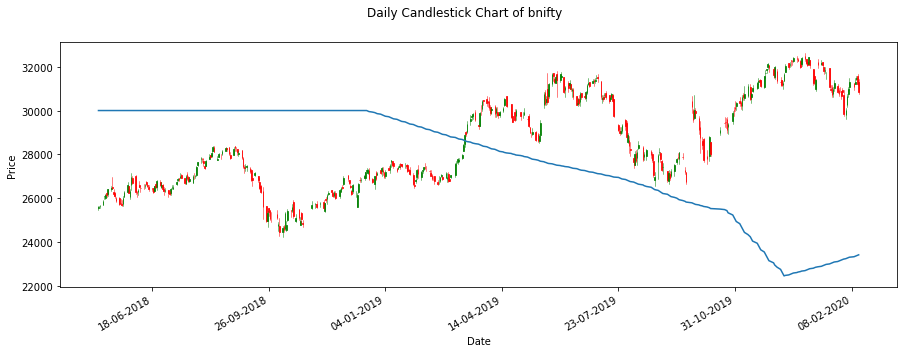

In [431]:
# Creating Subplots
fig, ax = plt.subplots(figsize=(15,5))

candlestick_ohlc(ax, plotbnifty.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
plt.plot(plotbnifty['Date'],bal)
# plt.plot(bnifty[a:]['Date'], bal,'k')
# plt.plot(bnifty[a:]['Date'], bnifty[a:]['sma'])
# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('Daily Candlestick Chart of bnifty')

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

#fig.tight_layout()len(bal)